In [13]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12,6)

import scipy.interpolate as ip
import pandas as pd
from datetime import datetime
import numpy as np
from tvm import TVM

Using matplotlib backend: MacOSX
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/wayne/Library/Mobile Documents/com~apple~CloudDocs/Python/APM466_3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Load data from the JSON files generated from webscraping

In [6]:
df1 = pd.read_json('data/08Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df2 = pd.read_json('data/09Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df3 = pd.read_json('data/10Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df4 = pd.read_json('data/11Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df5 = pd.read_json('data/12Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df6 = pd.read_json('data/15Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df7 = pd.read_json('data/16Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df8 = pd.read_json('data/17Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df9 = pd.read_json('data/18Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])
df10 = pd.read_json('data/19Jan.json').set_index(['name']).sort_values(['maturity date'], ascending=[True])

In [7]:
# Check that the data is consistent with our expectations

df1.head()

,isin,coupon,yield,maturity date,close
name,,,,,
CAN 1.5 May 24,ca135087n423,1.5000%,5.08%,2024-05-01,98.934
CAN 1.5 Sep 24,ca135087j967,1.5000%,4.85%,2024-09-01,97.960
CAN 0.7 Oct 24,ca135087m508,0.7500%,4.79%,2024-10-01,97.220
CAN 1.2 Mar 25,ca135087k528,1.2500%,4.59%,2025-03-01,96.460
CAN 1.5 Apr 25,ca135087n340,1.5000%,4.54%,2025-04-01,96.553


### Define utility functions 
#### Assumptions:
1. There are 365 days in a year
2. Today's date is 08 Jan 2024

In [40]:
def reformat_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    coupons = []
    df["maturity date"] = pd.to_datetime(df["maturity date"])
    # Remove the trailing percentage sign
    for row in range(df.shape[0]):
        coupons.append(float(df["coupon"][row][:-1]))

    df["coupon"] = coupons
    return df


from typing import List


def merge_dataframes(all_dataframes: List[pd.DataFrame]) -> pd.DataFrame:
    """Given a list of dataframes, merge them into one by creating 10 `close` columns, corresponding to each weekday."""
    basis = all_dataframes[0]  # basis of merging

    for df in range(10):
        new_close_column = all_dataframes[df]["close"]
        basis[f"close{df+1}"] = new_close_column

    # Add ttm to the basis
    ttm = []
    for row in range(basis.shape[0]):
        time_difference = datetime(2023, 1, 8) - basis["maturity date"][row]
        time_in_years = int(str(time_difference.days)[1:]) / 365
        ttm.append(time_in_years)

    basis["ttm"] = ttm
    basis = basis.drop("close", axis=1)  # drop the original close column

    return basis


def get_tr(df: pd.DataFrame) -> List[float]:
    tr = []
    for i, bond in df.iterrows():
        tr.append(bond["ttm"])
    return tr


def get_ytms(df: pd.DataFrame) -> List[List[float]]:
    """Generate the yields for each bond for each date in the specified range."""
    all_ytms = []

    for day in range(10):
        ytm_day = []

        for i, bond in df.iterrows():
            ttm = bond["ttm"]
            close = bond[f"close{day+1}"]
            freq = 2
            ytm = (
                TVM(n=ttm * freq, pv=-close, pmt=bond["coupon"] / freq, fv=100).calc_r()
                * freq
            )

            ytm_day.append(ytm)

        all_ytms.append(ytm_day)

    return all_ytms


def log_returns(x, y, the_list):
    log_returns = np.zeros((x, y))
    for i in range(len(the_list)):
        for j in range(len(the_list) - 1):
            log_returns[i][j] = math.log(the_list[i][j] / the_list[i][j + 1])

    return log_returns

### Reformat the dataframes

In [9]:
df1 = reformat_dataframe(df1)
df2 = reformat_dataframe(df2)
df3 = reformat_dataframe(df3)
df4 = reformat_dataframe(df4)
df5 = reformat_dataframe(df5)
df6 = reformat_dataframe(df6)
df7 = reformat_dataframe(df7)
df8 = reformat_dataframe(df8)
df9 = reformat_dataframe(df9)
df10 = reformat_dataframe(df10)

df1.head()

,isin,coupon,yield,maturity date,close
name,,,,,
CAN 1.5 May 24,ca135087n423,1.50,5.08%,2024-05-01,98.934
CAN 1.5 Sep 24,ca135087j967,1.50,4.85%,2024-09-01,97.960
CAN 0.7 Oct 24,ca135087m508,0.75,4.79%,2024-10-01,97.220
CAN 1.2 Mar 25,ca135087k528,1.25,4.59%,2025-03-01,96.460
CAN 1.5 Apr 25,ca135087n340,1.50,4.54%,2025-04-01,96.553


### Combine the dataframes into one

In [28]:
all_dataframes = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
df = merge_dataframes(all_dataframes).reset_index()

df.head()

,name,isin,coupon,yield,maturity date,close1,close2,close3,close4,close5,close6,close7,close8,close9,close10,ttm
0,CAN 1.5 May 24,ca135087n423,1.50,5.08%,2024-05-01,98.934,98.942,98.959,98.983,99.004,99.020,98.997,99.010,99.042,99.049,1.312329
1,CAN 1.5 Sep 24,ca135087j967,1.50,4.85%,2024-09-01,97.960,97.980,97.985,97.982,98.021,98.054,97.974,97.975,97.999,98.007,1.649315
2,CAN 0.7 Oct 24,ca135087m508,0.75,4.79%,2024-10-01,97.220,97.220,97.234,97.255,97.308,97.348,97.285,97.225,97.249,97.256,1.731507
3,CAN 1.2 Mar 25,ca135087k528,1.25,4.59%,2025-03-01,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460,2.145205
4,CAN 1.5 Apr 25,ca135087n340,1.50,4.54%,2025-04-01,96.553,96.545,96.591,96.640,96.720,96.680,96.620,96.500,96.490,96.490,2.230137


### Generate the yields for each of the bonds

In [29]:
# Since the ttm does not change much over 10 days, we can use the same one.

tr = get_tr(df)
all_ytms = get_ytms(df)

assert len(tr) == 10
assert len(all_ytms) == 10
for day in all_ytms:
    assert len(day) == 10

# tr[:2]
all_ytms[-2:]

[[0.022448950284747835,
  0.027492641062010607,
  0.02381207004834295,
  0.029480970488792977,
  0.0314200909175549,
  0.027699164441734554,
  0.03160769729033511,
  0.03016820564492571,
  0.031276805971899864,
  0.02999520900633515],
 [0.022394159682472284,
  0.027442031436077298,
  0.023769809040228896,
  0.02965438320306457,
  0.0314200909175549,
  0.027780841876024902,
  0.03170458185969058,
  0.030198584253616677,
  0.031247053688322497,
  0.029610697182634014]]

### Interpolation with Cubic Spline Interpolation
#### Justification for the choice of interpolation is given in the report pdf.

In [12]:
dates = ["08-Jan", "09-Jan", "10-Jan", "11-Jan", "12-Jan", "15-Jan", "16-Jan", "17-Jan", "18-Jan", "19-Jan"]

In [30]:
def cubic_spline_interpolate(
    all_ytms: List[List[float]], tr: List[float]
) -> List[List[float]]:
    """Perform cubic spline interploation for the yield curve data."""
    interploated_data = []

    for ys in all_ytms:
        cs = ip.CubicSpline(tr, ys, bc_type="natural")
        x = np.linspace(0, 5, 10)
        z = cs(x)

        interploated_data.append([float(i) for i in z])

    return interploated_data

In [31]:
all_ytms_interpolated = cubic_spline_interpolate(all_ytms=all_ytms, tr=tr)

all_ytms_interpolated[:2]

[[0.4930013022661238,
  0.09347347697738227,
  0.017249177188815995,
  0.02699876582349334,
  0.031034944175357376,
  0.02682026997373748,
  0.030743038919749482,
  0.02912877142640329,
  0.028573345218259334,
  0.03155766301284177],
 [0.47806939371745666,
  0.09106587999230137,
  0.017329894382125864,
  0.026898918277096777,
  0.03106024174668025,
  0.02664274102523185,
  0.030646043795693044,
  0.03092629296667558,
  0.027958810630539906,
  0.034566077859436516]]

### 5-Year Yield Curve 

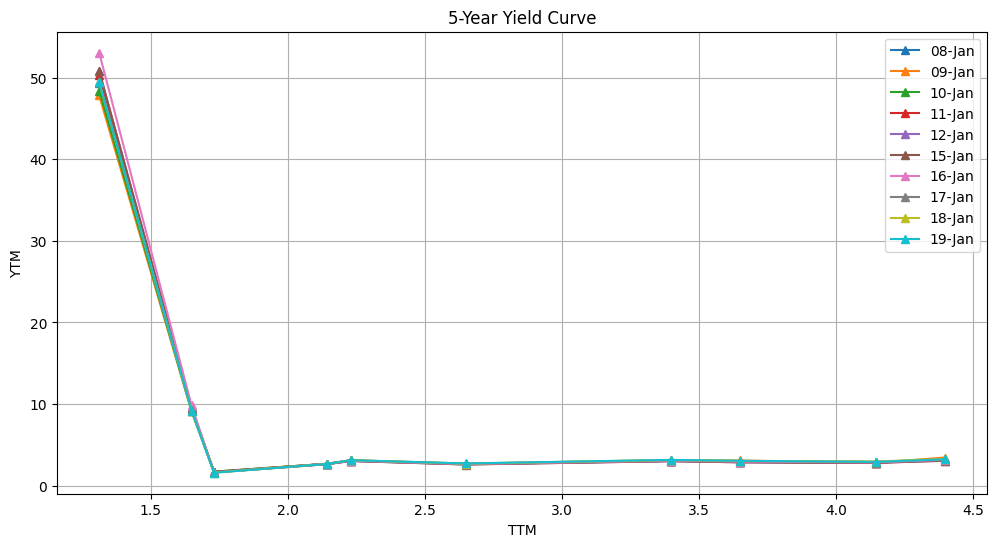

(<matplotlib.legend.Legend at 0x7f9418d31bb0>, None)

In [56]:
plt.xlabel("TTM"), plt.ylabel("YTM"), plt.title("5-Year Yield Curve"), grid(True)

for day in range(10):
    ytm = all_ytms_interpolated[day]
    curve_label = dates[day]
    plot(tr, array(ytm) * 100, marker="^", label=curve_label)

legend(loc=1), show()

### Spot Rate Curve

In [41]:
def get_spot_rate(day: List[List[float]], t: List[int]) -> List[float]:
    spot_rates = []

    for i in range(len(t)):
        _sum = 0
        for j in range(0, i):
            _sum += day[i] / (1 + spot_rates[j]) ** t[j]
        value = ((1 + day[i]) / (1 - _sum)) ** (1 / t[i]) - 1
        spot_rates.append(value)

    return spot_rates


def get_all_spot_rates(all_ytms: List[List[float]], t: List[int]) -> List[List[float]]:

    return [get_spot_rate(all_ytms[i], t) for i in range(10)]

In [38]:
# Bootstrapping method to compute the spot rates.
t = [i for i in range(1, df.shape[0] + 1)]

all_spot_rates = get_all_spot_rates(all_ytms_interpolated, t)

all_spot_rates[:2]

[[0.4930013022661237,
  0.08004898025832907,
  0.014705621584096829,
  0.02430728650765479,
  0.028769677244477654,
  0.02493992843894932,
  0.02922710783175897,
  0.027715368147496644,
  0.027279693990495346,
  0.030695929817448953],
 [0.4780693937174567,
  0.07828637794273563,
  0.014832921381548347,
  0.024282314960237583,
  0.02886091133638735,
  0.02481036974157691,
  0.02917773878703045,
  0.029658870008605343,
  0.02661853900452016,
  0.03412149574875789]]

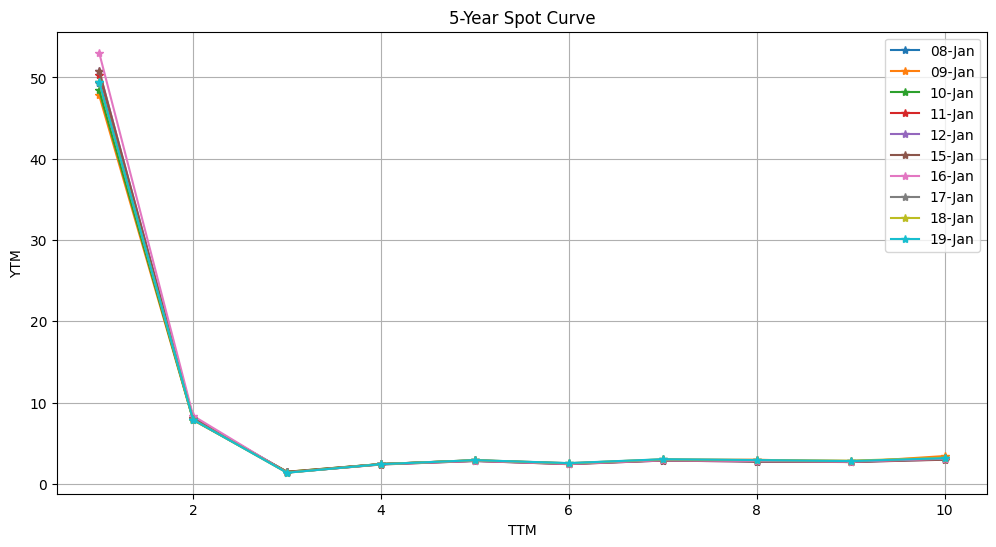

(<matplotlib.legend.Legend at 0x7f93f8b6f8e0>, None)

In [54]:
xlabel("TTM"), ylabel("YTM"), plt.title("5-Year Spot Curve"), grid(True)

for day in range(10):
    y_value = all_spot_rates[day]
    curve_label = dates[day]
    plot(t, array(y_value) * 100, marker="*", label=curve_label)

legend(loc=1), show()

### Forward rate curve

In [42]:
def get_forward_rate(spot_rates: List[float]) -> List[float]:
    daily_forward_rate = []
    r = spot_rates[2]
    counter = 3
    k = 2
    boundary = len(spot_rates)

    while counter < boundary:
        spot_rate = spot_rates[counter]
        forward_rate = float((spot_rate * k - r) / (k - 1))

        daily_forward_rate.append(forward_rate)

        k += 1
        counter += 2

    return daily_forward_rate


def get_all_forward_rates(all_spot_rates: List[List[float]]) -> List[List[float]]:

    return [get_forward_rate(all_spot_rates[i]) for i in range(10)]

In [43]:
all_forward_rates = get_all_forward_rates(all_spot_rates)

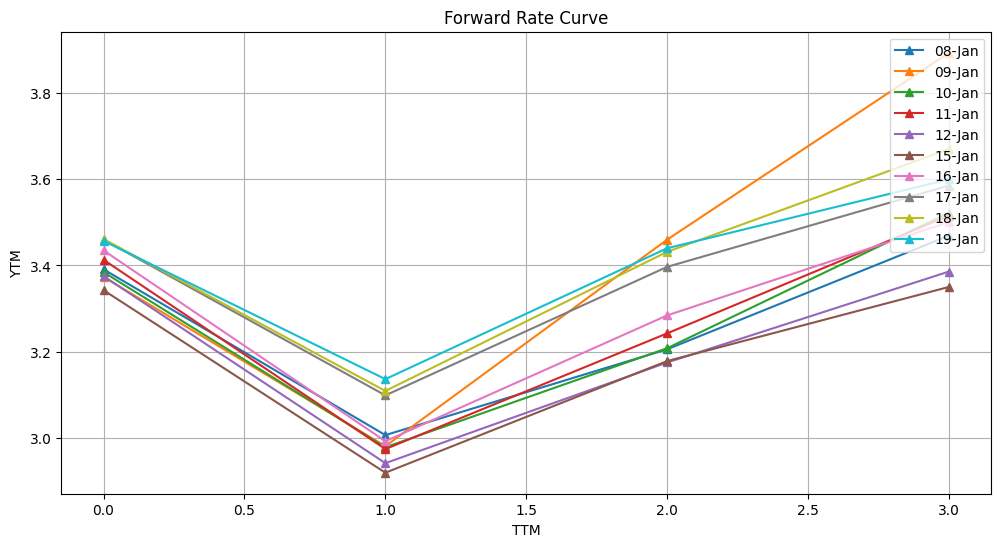

(<matplotlib.legend.Legend at 0x7f9418dc38e0>, None)

In [53]:
t_forward_rates = list(range(4))

xlabel("TTM"), ylabel("YTM"), plt.title("Forward Rate Curve"), grid(True)

for day in range(10):
    y_value_forward_rate = all_forward_rates[day]
    curve_label = dates[day]
    plot(
        t_forward_rates,
        array(y_value_forward_rate) * 100,
        marker="^",
        label=curve_label,
    )

legend(loc=1), show()

###  Covariance matrices for the time series of daily log-returns of yield

#### Covariance matrix for the random variables

In [46]:
ytms = []

for day in range(10):
    bond = 1
    daily_ytm = []
    boundary = len(all_ytms_interpolated[0])
    
    while bond < boundary:
        daily_ytm.append(all_ytms_interpolated[day][bond])
        bond += 2
        
    ytms.append(daily_ytm)

ytms_array = np.array(ytms).transpose()
ytms_cov_matrix = np.cov(log_returns(5, 9, ytms_array))

ytms_cov_matrix

array([[ 1.96666245e-04,  2.21960437e-06, -4.72416465e-06,
        -2.50946354e-04, -4.15332628e-04],
       [ 2.21960437e-06,  1.06914620e-05,  1.10947951e-05,
         2.75833936e-06,  6.05484313e-06],
       [-4.72416465e-06,  1.10947951e-05,  1.44850548e-05,
        -1.00540998e-05, -9.09881420e-06],
       [-2.50946354e-04,  2.75833936e-06, -1.00540998e-05,
         9.65764536e-04,  1.37006680e-03],
       [-4.15332628e-04,  6.05484313e-06, -9.09881420e-06,
         1.37006680e-03,  1.97323692e-03]])

#### Covariance matrix for the forward rates (1yr-1yr until 1yr-4yr)

In [50]:
forward_rates = []

for day in range(10):
    j = 0
    daily_forward_rate = []
    boundary = len(all_forward_rates[0])

    while j < boundary:
        daily_forward_rate.append(all_forward_rates[day][j])
        j += 1

    forward_rates.append(daily_forward_rate)

forward_rate_array = np.array(forward_rates).transpose()
forward_rate_cov = np.cov(log_returns(4, 9, forward_rate_array))

forward_rate_cov

array([[ 1.31711417e-05,  4.82145456e-06, -7.13526291e-05,
        -1.20656882e-04],
       [ 4.82145456e-06,  7.98236007e-06, -7.45630047e-05,
        -1.11578660e-04],
       [-7.13526291e-05, -7.45630047e-05,  1.46162415e-03,
         2.05062336e-03],
       [-1.20656882e-04, -1.11578660e-04,  2.05062336e-03,
         2.92550484e-03]])

### Eigenvalues and eigenvalues for random variables matrix

In [51]:
ytm_eigenvalues, ytm_eigenvectors = np.linalg.eig(ytms_cov_matrix)

print("The eigenvalues for the log-returns of yield are: \n", ytm_eigenvalues)
print("\n\n")

print("The eigenvectors for the log-returns of yield are: \n", ytm_eigenvectors)

The eigenvalues for the log-returns of yield are: 
 [3.01257432e-03 1.22731225e-04 2.38895111e-05 4.89123472e-20
 1.64916640e-06]



The eigenvectors for the log-returns of yield are: 
 [[-0.16947759 -0.94678809 -0.06064221 -0.22749992  0.13941295]
 [ 0.00200875 -0.01877334 -0.65382386  0.56150152  0.50682732]
 [-0.00406774  0.06683801 -0.74984617 -0.39698722 -0.52502191]
 [ 0.56248086 -0.31363763  0.05882987  0.54117488 -0.53750862]
 [ 0.80924165  0.02009955 -0.05573735 -0.42718934  0.39890673]]


### Eigenvalues and eigenvalues for forward rates matrix

In [52]:
forward_rate_eigenvalues, forward_rate_eigenvectors = np.linalg.eig(forward_rate_cov)

print("The eigenvalues for the forward rates are: \n", forward_rate_eigenvalues)
print("\n\n")

print("The eigenvectors for the forward rates are: \n", forward_rate_eigenvectors)

The eigenvalues for the forward rates are: 
 [4.37949887e-03 2.47010967e-05 2.78382464e-19 4.08252236e-06]



The eigenvectors for the forward rates are: 
 [[ 0.03200403  0.56965455 -0.7144354  -0.40503271]
 [ 0.03069425  0.14333678 -0.3977948   0.90568854]
 [-0.57547057  0.67432145  0.44942706  0.11017951]
 [-0.81661939 -0.44748055 -0.35966188 -0.05947485]]
